In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Ler dados

In [23]:
# Acao Extensiva

df = pd.read_csv("data/AE_GO_RO.csv", low_memory=False)
df2 = pd.read_csv("data/AE_MS_SE.csv", low_memory=False)
df = df.loc[df.DR=="RO"]
df = pd.concat([df, df2])

# Cursos
df_curso = pd.read_csv("data/Curso_GO_RO.csv")
df_curso2 = pd.read_csv("data/Curso_MS_SE.csv")
df_curso = pd.concat([df_curso, df_curso2])

# Uops

df_uop = pd.read_csv("data/UOP.csv")

df = df.merge(df_uop[["Codigo_Unidade", "codigo_ibge"]], left_on="Cod_Unidade",
             right_on="Codigo_Unidade", how="left")

for col in "Data_Nascimento", 'Data_Matricula', 'Data_Status_Matricula', 'Data_Inicio', 'Data_Fim': 
    df[col] = pd.to_datetime(df[col])
    
    

### Features Engineering

In [24]:
# Aluno matriculado em mais de um curso?

mat_alunos = df.groupby(["Doc_Identificacao"]).nunique()["Cod_Curso_Senac"].reset_index()
mat_alunos.loc[mat_alunos["Cod_Curso_Senac"]>1, "multicurso"] = 1
mat_alunos.fillna(0, inplace=True)
#mat_alunos.sort_values("Cod_Curso_Senac", ascending=False)
df = df.merge(mat_alunos[["Doc_Identificacao", "multicurso"]], 
              on="Doc_Identificacao", how="left")

# Aluno matriculado no mesmo municipio da unidade

df.loc[df.Municipio_Residencia_Aluno==df.codigo_ibge ,"mesmomuni"] = 1
df['mesmomuni'].fillna(0, inplace=True)

### Criação de bins

In [25]:
df["idade"] = np.round((datetime.now() - df["Data_Nascimento"])/np.timedelta64(1,"Y")).astype("int")
df["duracao"] = (df['Data_Fim'] - df['Data_Inicio']).dt.days
df['bins_idade'] = pd.cut(x=df['idade'], bins=[0,14, 20, 25, 30,
                                          40, 50, 60, 100], 
                         labels=[0, 1,2,3,4,5,6,7])

df['bins_CH'] = pd.cut(x=df['Carga_Horaria_Turma'], bins=[-1, 0, 30, 100, 6000], 
                         labels=[0,1,2,3])
df['bins_CHE'] = pd.cut(x=df['Carga_Horaria_Estagio_Turma'], bins=[-1, 0, 200, 700, 3000], 
                         labels=[0, 1,2,3])

df['bins_CHE'].fillna(0, inplace=True)
df['bins_CHE'] = df['bins_CHE'].astype(int)
df['bins_CH'].fillna(0, inplace=True)
df['bins_CH'] = df['bins_CH'].astype(int)
df = df.loc[~df["idade"]<100]
df['bins_idade'] = df['bins_idade'].astype(int)

df.drop(['idade', 'Carga_Horaria_Turma','Carga_Horaria_Estagio_Turma'], axis=1, inplace=True)

### Coluna Evadido (target)

In [26]:
df.loc[df.Cod_Esp_Matricula==3, "evadido"] = 1
df["evadido"].fillna(0, inplace=True)

## EDA

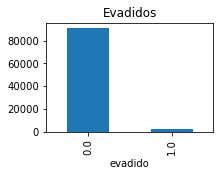

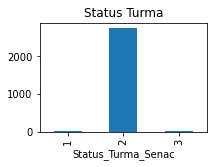

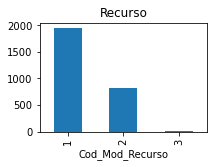

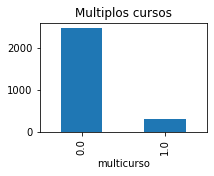

<AxesSubplot:title={'center':'Mesmo Muni'}, xlabel='mesmomuni'>

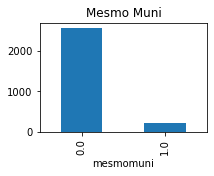

In [27]:
df.groupby("evadido")["Matricula_Apurada_Mes"].sum().plot(kind="bar", 
                                                          title="Evadidos",
                                                         figsize=(3,2))
plt.show()
df.loc[df.evadido==1].groupby("Status_Turma_Senac")["Matricula_Apurada_Mes"].\
sum().plot(kind="bar",title="Status Turma",figsize=(3,2))
plt.show()

df.loc[df.evadido==1].groupby("Cod_Mod_Recurso")["Matricula_Apurada_Mes"].sum().plot(kind="bar",
                                                                            title="Recurso",
                                                                             figsize=(3,2))
plt.show()

df.loc[df.evadido==1].groupby("multicurso")["Matricula_Apurada_Mes"].sum().plot(kind="bar",
                                                                            title="Multiplos cursos",
                                                                             figsize=(3,2))


plt.show()

df.loc[df.evadido==1].groupby("mesmomuni")["Matricula_Apurada_Mes"].sum().plot(kind="bar",
                                                                           title="Mesmo Muni",
                                                                           figsize=(3,2))


In [28]:
df = df.loc[df.Status_Turma_Senac==2]

### Merge com cursos

In [29]:
df = df[["DR", 'Cod_Curso_Senac', 'Tipo_Ensino',
         'Cod_Mod_Recurso', 'Cod_Origem', 'Cod_Nacionalidade','Atestado_Baixa_Renda', 'Sexo', 'Cod_Raca', 'Cod_Escolaridade',
           'Cod_Estado_Civil',  'Deficiencia', 'Trabalha_Atualmente', 'Cod_Renda_Familiar', 'Contrato_Aprendizagem',
           'CursoId', "bins_idade", "bins_CH", "bins_CHE", 'multicurso','mesmomuni','evadido']]

df_curso = df_curso[["Id_Curso", 'Id_Eixo', 'Id_Modalidade', 'Id_TipoCurso','Regional']].drop_duplicates()
df_curso["Regional"] = df_curso["Regional"].str.strip()

df = df.merge(df_curso, left_on=["DR",  'Cod_Curso_Senac'],
             right_on=["Regional", "Id_Curso"], how="left")

df.drop(["DR", "Regional", "Id_Curso", "Cod_Curso_Senac"], axis=1, inplace=True)

33033
Tipo_Ensino                  0
Cod_Mod_Recurso              0
Cod_Origem                   1
Cod_Nacionalidade            0
Atestado_Baixa_Renda         0
Sexo                         0
Cod_Raca                  8284
Cod_Escolaridade          3131
Cod_Estado_Civil          8090
Deficiencia                  0
Trabalha_Atualmente      16951
Cod_Renda_Familiar       16987
Contrato_Aprendizagem        0
CursoId                      0
bins_idade                   0
bins_CH                      0
bins_CHE                     0
multicurso                   0
mesmomuni                    0
evadido                      0
Id_Eixo                      0
Id_Modalidade                0
Id_TipoCurso                 0
dtype: int64
---------
% evadido 0.20107165561711016


<AxesSubplot:title={'center':'Evadidos turmas concluidas'}, xlabel='evadido'>

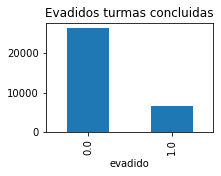

In [30]:
print(len(df))
print(df.isna().sum())
print("---------")
print("% evadido",len(df.loc[df.evadido==1])/len(df))
df.groupby("evadido")["Tipo_Ensino"].count().plot(kind="bar", 
                                                title="Evadidos turmas concluidas",
                                                figsize=(3,2))

### Correlation

In [31]:
corr = df.corr()

<AxesSubplot:>

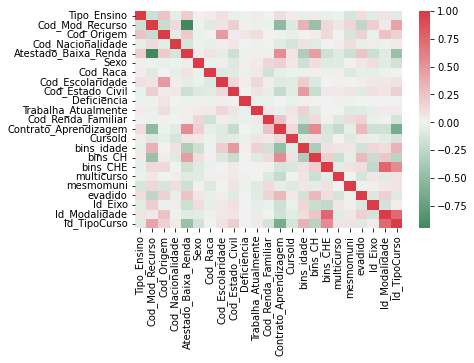

In [32]:
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
            cmap=cmap, center=0)

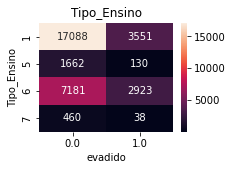

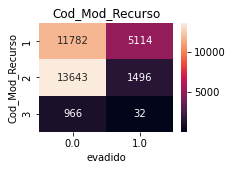

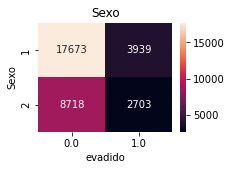

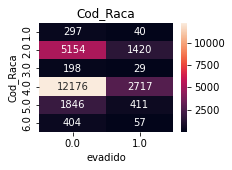

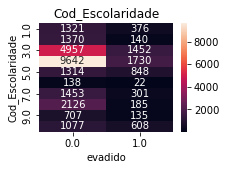

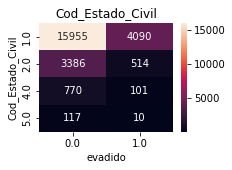

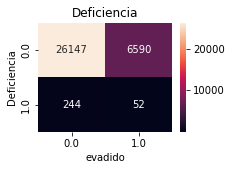

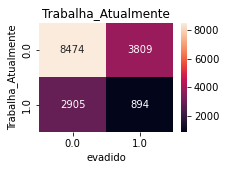

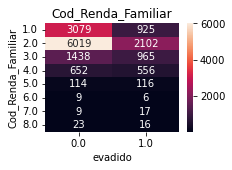

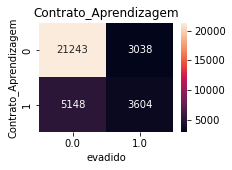

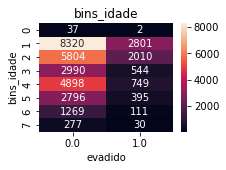

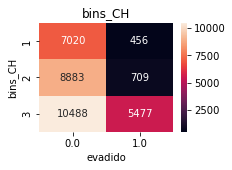

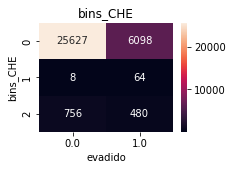

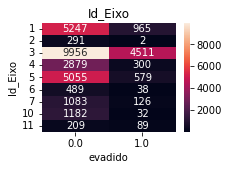

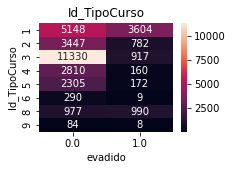

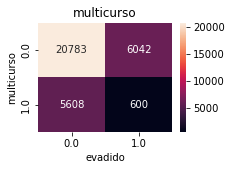

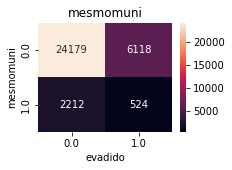

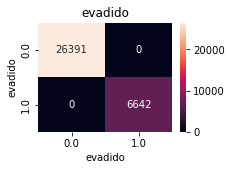

In [33]:
import seaborn as sns

df = df[['Tipo_Ensino', 'Cod_Mod_Recurso', 'Sexo', 'Cod_Raca',
         'Cod_Escolaridade', 'Cod_Estado_Civil', 'Deficiencia',
         'Trabalha_Atualmente', 'Cod_Renda_Familiar', 'Contrato_Aprendizagem',
         'bins_idade', 'bins_CH', 'bins_CHE', 'Id_Eixo',
         'Id_TipoCurso', "multicurso", "mesmomuni","evadido"]]

for c in df.columns:
    fig, ax = plt.subplots(figsize=(3,2))
    sns.heatmap(pd.crosstab(df[c],df.evadido), annot=True, fmt="d", ax=ax)
    plt.title(c)
    plt.show()
    


### Onehot

In [80]:
print(len(df))
df = df.dropna()
print(len(df))

33033
14414


In [81]:
df_dum = pd.get_dummies(df, prefix=[c for c in df.columns[:-1]], 
                        columns = [c for c in df.columns[:-1]], 
                        drop_first=False)

In [82]:
print(len(df_dum.columns))
df_dum.columns

78


Index(['evadido', 'Tipo_Ensino_1', 'Tipo_Ensino_5', 'Tipo_Ensino_6',
       'Tipo_Ensino_7', 'Cod_Mod_Recurso_1', 'Cod_Mod_Recurso_2',
       'Cod_Mod_Recurso_3', 'Sexo_1', 'Sexo_2', 'Cod_Raca_1.0', 'Cod_Raca_2.0',
       'Cod_Raca_3.0', 'Cod_Raca_4.0', 'Cod_Raca_5.0', 'Cod_Raca_6.0',
       'Cod_Escolaridade_1.0', 'Cod_Escolaridade_2.0', 'Cod_Escolaridade_3.0',
       'Cod_Escolaridade_4.0', 'Cod_Escolaridade_5.0', 'Cod_Escolaridade_6.0',
       'Cod_Escolaridade_7.0', 'Cod_Escolaridade_8.0', 'Cod_Escolaridade_9.0',
       'Cod_Escolaridade_10.0', 'Cod_Estado_Civil_1.0', 'Cod_Estado_Civil_2.0',
       'Cod_Estado_Civil_4.0', 'Cod_Estado_Civil_5.0', 'Deficiencia_0.0',
       'Deficiencia_1.0', 'Trabalha_Atualmente_0.0', 'Trabalha_Atualmente_1.0',
       'Cod_Renda_Familiar_1.0', 'Cod_Renda_Familiar_2.0',
       'Cod_Renda_Familiar_3.0', 'Cod_Renda_Familiar_4.0',
       'Cod_Renda_Familiar_5.0', 'Cod_Renda_Familiar_6.0',
       'Cod_Renda_Familiar_7.0', 'Cod_Renda_Familiar_8.0',
       

## ML

In [83]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

### Feature Selection

In [84]:
df_teste = df_dum.dropna()

X = df_teste[[c for c in df_teste.columns[1:]]]

y = df_teste.evadido
print("% evadidos = ", (y[y==1].sum())/len(y))

% evadidos =  0.2698765089496323


#### Melhores variaveis com chi_square

In [86]:
f = 77
bestfeatures = SelectKBest(score_func=chi2, k=f)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score_chi']  #naming the dataframe columns

#### Melhores variaveis com f_classif

In [87]:
bestfeatures = SelectKBest(score_func=f_classif, k=f)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores_f = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_f.columns = ['Specs','Score_F']  #naming the dataframe columns
featureScores = featureScores.merge(featureScores_f, on="Specs")

#### Melhores variaveis com mutual info

In [88]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=f)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores_m = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_m.columns = ['Specs','Score_mut']  #naming the dataframe columns
featureScores = featureScores.merge(featureScores_m, on="Specs")

#### Feature importance com Tree

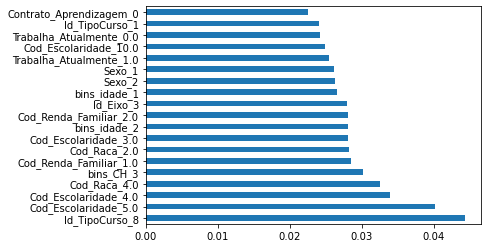

In [89]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X,y)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(19).plot(kind='barh')
plt.show()

In [90]:
feat_importances.name = "Tree Class"
featureScores = featureScores.merge(feat_importances, left_on="Specs", right_index=True)

In [91]:
featureScores.sort_values("Score_F", ascending=False)

,Specs,Score_chi,Score_F,Score_mut,Tree Class
52,bins_CH_3,411.795864,1218.345093,0.047320,0.030097
67,Id_TipoCurso_3,656.604382,1079.214966,0.038829,0.022149
41,Contrato_Aprendizagem_0,371.220035,948.792175,0.034067,0.022493
42,Contrato_Aprendizagem_1,519.090378,948.791077,0.032668,0.020337
65,Id_TipoCurso_1,519.090378,948.791077,0.025156,0.024062
...,...,...,...,...,...
1,Tipo_Ensino_5,1.848157,1.848778,0.000000,0.000004
15,Cod_Escolaridade_1.0,1.144501,1.217655,0.001747,0.014375
38,Cod_Renda_Familiar_6.0,0.541078,0.541550,0.004303,0.001131
11,Cod_Raca_3.0,0.017412,0.017527,0.000000,0.002209


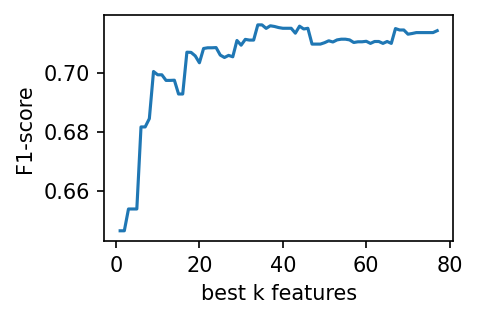

In [92]:
import sklearn.feature_selection as fs
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


f1_list = []
for k in range(1, 78):
    bk = fs.SelectKBest(score_func=f_classif, k=k)
    bk.fit(X, y)
    X_trans = bk.transform(X)
    train_x, test_x, train_y, test_y = train_test_split(X_trans,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=42)
    lr = LogisticRegression(max_iter=1000, class_weight="balanced")
    lr.fit(train_x, train_y)
    y_pred = lr.predict(test_x)
    f1 = metrics.roc_auc_score(test_y, y_pred)
    f1_list.append(f1)

fig, axe = plt.subplots(dpi = 150, figsize=(3,2))
axe.plot(range(1, 78), f1_list)
axe.set_xlabel("best k features")
axe.set_ylabel("F1-score")
plt.show()

#### Analise de variancia

In [93]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(0.2)
sel.fit(X,y)

VarianceThreshold(threshold=0.2)

In [94]:
_X = pd.DataFrame({"feature":sel.feature_names_in_,"variancia":sel.variances_}).sort_values("variancia", 
                                                                                            ascending=False)
_X

,feature,variancia
34,Cod_Renda_Familiar_2.0,0.249950
0,Tipo_Ensino_1,0.248797
2,Tipo_Ensino_6,0.247329
42,Contrato_Aprendizagem_1,0.243104
41,Contrato_Aprendizagem_0,0.243104
...,...,...
6,Cod_Mod_Recurso_3,0.002146
39,Cod_Renda_Familiar_7.0,0.001801
70,Id_TipoCurso_6,0.001386
38,Cod_Renda_Familiar_6.0,0.000970


In [95]:
selected_X = _X.loc[_X.variancia>=0.2]['feature'].values

### Comparação de modelos default

In [96]:
from sklearn.model_selection import train_test_split, GridSearchCV

# X_ = X[selected_X]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [98]:
model_pipeline = []
model_pipeline.append(LogisticRegression())
model_pipeline.append(SVC(probability=True))
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())

In [99]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [100]:
model_list = ["Logistic Regression", "SVM", "KNN", 
              "Decision Tree", "Random Forest", "Naive Bayes"]
acc_list = []
auc_list = []
cm_list =[]
auc_rc_list= []

for model in model_pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
    auc_list.append(round(metrics.auc(fpr, tpr), 2))
    cm_list.append(confusion_matrix(y_test, y_pred))
    pr, rc, _threshold = metrics.precision_recall_curve(y_test, y_prob[:,1])
    auc_rc_list.append(metrics.auc(rc, pr))

C:\Users\paula\Anaconda3\envs\evasao\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


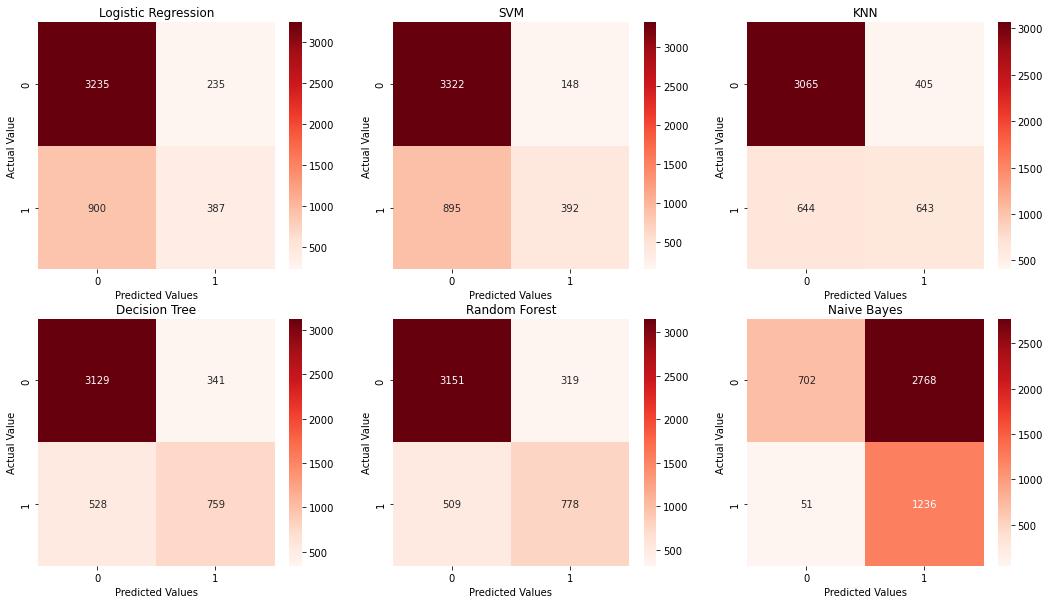

In [101]:
fig = plt.figure(figsize=(18,10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2,3,i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True, cmap="Reds", fmt="d")
    cm_plot.set_ylabel("Actual Value")
    cm_plot.set_xlabel("Predicted Values")

In [102]:
results_df = pd.DataFrame({"Model": model_list,
                          "Accuracy": acc_list,
                          "AUC": auc_list,"AUC_PR": auc_rc_list})
results_df.sort_values("Accuracy", ascending=False)

,Model,Accuracy,AUC,AUC_PR
4,Random Forest,0.825941,0.76,0.737014
3,Decision Tree,0.817322,0.75,0.734613
1,SVM,0.780744,0.63,0.634502
2,KNN,0.779483,0.69,0.628463
0,Logistic Regression,0.761404,0.62,0.559652
5,Naive Bayes,0.407400,0.58,0.634269


### Random Forest 

In [171]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

In [172]:
def criar_preds(y_pred):
    df_pred = pd.DataFrame(y_pred)
    df_pred["evadido"] = y_test.values
    return df_pred

def plotar_preds(df_pred, x=0.5):
    plt.hist(df_pred.loc[df_pred.evadido==0][0], bins=30)
    plt.title("Prob de ser 0")
    plt.xlabel("Probabilidade do modelo")
    plt.ylabel("alunos não evadidos")
    plt.show()
    plt.hist(df_pred.loc[df_pred.evadido==1][1], bins=30)
    plt.title("Prob de ser 1")
    plt.xlabel("Probabilidade do modelo")
    plt.ylabel("alunos evadidos")
    plt.vlines(x, 0, 100, 'r', '-')
    plt.show()
    
def criar_cm(df_pred, limite=0.2):
    
    df_pred = pd.DataFrame(y_pred)
    df_pred["evadido"] = y_test.values
    df_pred.loc[df_pred[1] > limite, "pred"] = 1
    df_pred.pred.fillna(0, inplace=True)
    df_pred.loc[(df_pred.pred==0) & (df_pred.evadido==0), "res"] = "TN"
    df_pred.loc[(df_pred.pred==0) & (df_pred.evadido==1), "res"] = "FN"
    df_pred.loc[(df_pred.pred==1) & (df_pred.evadido==0), "res"] = "FP"
    df_pred.loc[(df_pred.pred==1) & (df_pred.evadido==1), "res"] = "TP"
    cm = pd.DataFrame(df_pred.groupby("res").count()["pred"]).reset_index()
    
    return cm

def calcular_metricas(cm):
    recall = cm.loc[cm["res"]=="TP"]["pred"].values / (cm.loc[cm["res"]=="TP"]["pred"].values + cm.loc[cm["res"]=="FN"]["pred"].values)
    precision = cm.loc[cm["res"]=="TP"]["pred"].values / (cm.loc[cm["res"]=="TP"]["pred"].values + cm.loc[cm["res"]=="FP"]["pred"].values)
    f1 = (2 * precision * recall) / (precision + recall)
    return recall, precision, f1

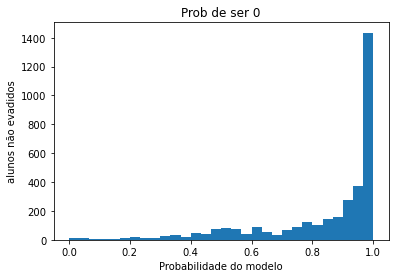

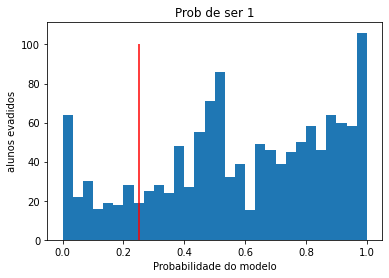

  res  pred
0  FN   169
1  FP   979
2  TN  2491
3  TP  1118
[0.86868687] [0.53314258] [0.6607565]


In [173]:
df_pred = criar_preds(y_pred)
plotar_preds(df_pred, x=0.25)
cm = criar_cm(df_pred, limite=0.2)
print(cm)
recall, precision, f1 = calcular_metricas(cm)
print(recall, precision, f1)

### BalancedRandomForest

In [164]:
# random forest for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# define model
#model = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')
model = BalancedRandomForestClassifier(n_estimators=50)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
#
output = cross_validate(model, X, y, cv=cv, scoring = 'roc_auc', return_estimator =True)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.888


In [165]:
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
                      importance
Id_TipoCurso_3          0.038090
bins_CH_3               0.037467
Cod_Escolaridade_4.0    0.035702
Cod_Escolaridade_5.0    0.032809
Cod_Raca_4.0            0.030644
...                          ...
bins_idade_7            0.000526
Id_TipoCurso_9          0.000491
Cod_Mod_Recurso_3       0.000113
Id_TipoCurso_6          0.000081
Tipo_Ensino_5           0.000017

[77 rows x 1 columns]
Features sorted by their score for estimator 1:
                         importance
bins_CH_3                  0.045574
Cod_Escolaridade_5.0       0.038688
Cod_Escolaridade_4.0       0.037284
Contrato_Aprendizagem_0    0.033034
Cod_Raca_4.0               0.032256
...                             ...
bins_idade_7               0.000431
Id_Eixo_2                  0.000251
Id_TipoCurso_6             0.000114
Cod_Mod_Recurso_3          0.000023
Tipo_Ensino_5              0.000015

[77 rows x 1 columns]
Features sorted by their score

                      importance
Id_TipoCurso_3          0.041129
Cod_Escolaridade_5.0    0.034621
Cod_Escolaridade_4.0    0.034247
Id_Eixo_3               0.034040
Cod_Raca_4.0            0.033759
...                          ...
Id_TipoCurso_9          0.000414
Id_Eixo_2               0.000197
Id_TipoCurso_6          0.000103
Cod_Mod_Recurso_3       0.000033
Tipo_Ensino_5           0.000001

[77 rows x 1 columns]
Features sorted by their score for estimator 27:
                      importance
Cod_Escolaridade_4.0    0.040095
Id_TipoCurso_1          0.035310
Id_TipoCurso_8          0.034125
Cod_Escolaridade_5.0    0.033712
Cod_Raca_4.0            0.032470
...                          ...
Id_TipoCurso_9          0.000576
Id_Eixo_2               0.000371
Cod_Mod_Recurso_3       0.000233
Id_TipoCurso_6          0.000107
Tipo_Ensino_5           0.000004

[77 rows x 1 columns]
Features sorted by their score for estimator 28:
                      importance
Cod_Escolaridade_5.0    0.03772

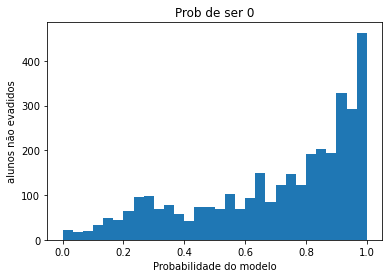

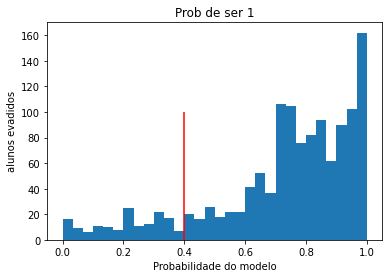

  res  pred
0  FN   157
1  FP  1076
2  TN  2394
3  TP  1130


(array([0.87801088]), array([0.51223935]), array([0.6470083]))

In [168]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

df_pred = criar_preds(y_pred)
plotar_preds(df_pred, 0.4)

cm = criar_cm(df_pred, 0.4)
print(cm)
calcular_metricas(cm)

### Logistic Regression

In [169]:
model = LogisticRegression(class_weight="balanced", solver="liblinear")
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

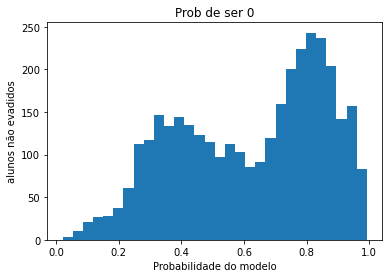

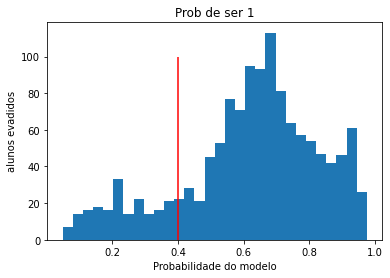

  res  pred
0  FN   198
1  FP  1512
2  TN  1958
3  TP  1089


(array([0.84615385]), array([0.41868512]), array([0.56018519]))

In [170]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

df_pred = criar_preds(y_pred)
plotar_preds(df_pred, 0.4)

cm = criar_cm(df_pred, 0.4)
print(cm)
calcular_metricas(cm)

### Grid search

In [122]:
# define hyperparameters
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
crange = np.arange(0, 20.0, 0.25)
hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l1", "l2"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]}

In [123]:
lg4 = LogisticRegression(random_state=13)# define evaluation procedure
grid = GridSearchCV(lg4, hyperparam_grid, scoring="roc_auc", cv=3, n_jobs=-1, refit=True)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

C:\Users\paula\Anaconda3\envs\evasao\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
16800 fits failed out of a total of 33600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16800 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\paula\Anaconda3\envs\evasao\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\paula\Anaconda3\envs\evasao\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\paula\Anaconda3\envs\evasao\lib\site-packages\sklearn\linear_model\_logistic.p

Best score: 0.7449448902156487 with param: {'C': 8.0, 'class_weight': {0: 0.005, 1: 1.0}, 'fit_intercept': True, 'penalty': 'l2'}


C:\Users\paula\Anaconda3\envs\evasao\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [161]:
GridSearchCV?

In [ ]:
lg4.fit(C=8, clas)
y_pred = lg4.predict_proba(X_test)

#### Naive Bayes

In [162]:
model = GaussianNB()
model.fit(X_train, y_train, )
y_pred = model.predict_proba(X_test)

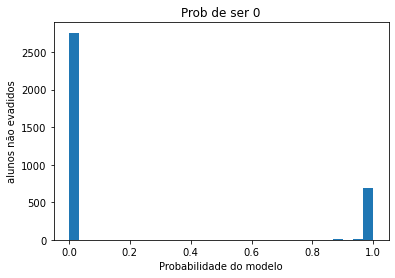

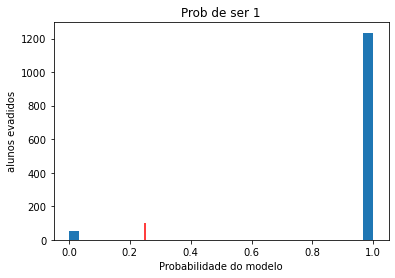

  res  pred
0  FN    51
1  FP  2774
2  TN   696
3  TP  1236


(array([0.96037296]), array([0.30822943]), array([0.46667925]))

In [163]:
df_pred = criar_preds(y_pred)
plotar_preds(df_pred, 0.25)

cm = criar_cm(df_pred, 0.25)
print(cm)
calcular_metricas(cm)

In [ ]:
df_pred = pd.DataFrame(y_pred)
df_pred["evadido"] = y_test.values
plt.hist(df_pred.loc[df_pred.evadido==0][0], bins=15)
plt.show()
plt.hist(df_pred.loc[df_pred.evadido==1][1], bins=15)
plt.show()